В этом ноутбуке собраны полезные кусочки кода для хакатона по машинному зрению.
Исходная задача, датасет, алгоритмы и правила оценки - https://www.kaggle.com/c/whale-categorization-playground.

In [231]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from skimage.data import imread
import matplotlib.pyplot as plt
import os

# Базовый класс для классификатора китов

In [232]:
class WhaleClassifierBase(object):
    '''Базовый класс клаффисикатора китов по изображениям.
    Наследуйте свой классификатор от этого класса, чтобы не переписывать загрузку данных и получать готовую структуру для вычисления метрики качества MAP@5.'''
    
    def __init__(self):
        self.DF_train = pd.DataFrame()
        pass
    
    def load_train_data(self, train_csv_filename='.\\input\\train.csv'):
        '''Загрузить тренировочный датасет из файла. Загрузка изображений не производится.
        :param train_csv_filename: путь к файлу train.csv с парами (файл картинки, id кита), по умолчанию ".\\input\\train.csv"
        :returns: датафрейм pandas с индексом Image и столбцом Id
        '''
        
        # reading train dataset
        self.DF_train = pd.read_csv(train_csv_filename, index_col='Image')
        
    def load_image(self, filename, train_img_folder='.\\input\\train'):
        '''Загрузить картинку из файла.
        :param filename: название файла картинки (можно брать из изндекса датафрейма)
        :param train_img_folder: путь к папке с картинками, по умолчанию ".\\input\\train"
        :returns: ndarray картинки, см. документацию sklearn.imread
        '''
        file_path = os.path.join(train_img_folder, filename)
        if not(os.path.isfile(file_path)):
            return None

        img = imread(file_path)
        return img
    
    # @abstract
    def get_single_predictions(self, image, train_img_folder='.\\input\\train'):
        '''Предсказкать до 5 id китов на одной картинке.
        :param image: название картинки
        :returns: список [image, [id1, id2,.. id5]] с предсказаниями id для картинки'''
        
        # todo: заменитие этот метод на свой алгоритм
        
        return [image, []]
    
    def get_batch_predictions(self, images, train_img_folder='.\\input\\train'):
        '''Предсказкать до 5 id китов для каждой картинки из списка.
        :param images: список названий картинок
        :returns: список с предсказаниями id для всех картинок из списка'''
        
        return [self.get_single_predictions(image, train_img_folder) for image in images]
    
    def write_submission_file(self, predictions, output_filename):
        submission = pd.DataFrame(predictions, columns=['Image', 'Id']).set_index('Image')
        submission.to_csv(output_filename)
        
        return submission

# Пример реализации классификатора - most common ids

In [233]:
class MostCommonIdWhaleClassifier(WhaleClassifierBase):
    '''Пример реализации классификатора китов - всегда возвращает 5 самых частых id.
    '''
    def __init__(self):
        super(MostCommonIdWhaleClassifier, self).__init__()
        self.__most_common_ids = None
        
    def _get_most_common_ids(self):
        '''Вычисление 5 самых частотных id китов.
        Код взят из кернела 'Most common Id benchmark' - https://www.kaggle.com/inversion/most-common-id-benchmark/notebook
        '''
        if self.__most_common_ids is None:
            self.__most_common_ids = self.DF_train['Id'].value_counts().nlargest(5).index.tolist()
        
        return self.__most_common_ids
    
    def get_single_predictions(self, image, train_img_folder='.\\input\\train'):
        ids = self._get_most_common_ids()
        return [image, ids]

Пример использования классификатора

In [234]:
w = MostCommonIdWhaleClassifier()
w.load_train_data()

predictions = w.get_batch_predictions(['00022e1a.jpg', '000466c4.jpg', '00087b01.jpg'])
    
sub = w.write_submission_file(predictions, 'sub.csv')
sub

,Id
Image,
00022e1a.jpg,"[new_whale, w_1287fbc, w_98baff9, w_7554f44, w..."
000466c4.jpg,"[new_whale, w_1287fbc, w_98baff9, w_7554f44, w..."
00087b01.jpg,"[new_whale, w_1287fbc, w_98baff9, w_7554f44, w..."


Пример загрузки картинки

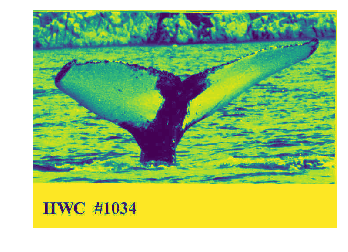

In [235]:
img = w.load_image('00022e1a.jpg')
# img2 = imread('.\\input\\train\\00022e1a.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

# Класс для оценки качества обучения на локальной машине

In [236]:
class Map5Evaluator:
    '''Helper class to evaluate model quality by MAP@5 metric. '''
    
    def evaluate(predictions, expected):
        '''Рассчитать точность предсказаний по метрике MAP@5, см. https://www.kaggle.com/c/whale-categorization-playground#evaluation .
        :param results: список предсказанных id вида [[image, [id1, id2,.. id5]],..] 
        :param expected: список ожидаемых значений вида [[image, id],..]
        :returns: значение метрики MAP@5
        '''
        df = pd.DataFrame(predictions, columns=['Image', 'Ids']).set_index('Image')
        df = df.join(pd.DataFrame(expected, columns=['Image', 'Expected_id']).set_index('Image'))
        df['Relevance'] = df.apply(lambda s: Map5Evaluator._calc_precision_vector(s['Ids'], s['Expected_id']), axis=1)
        
        return Map5Evaluator._mean_average_precision(df['Relevance'].tolist())
    
    def _calc_precision_vector(ids, expected_id):
        return [int(expected_id in ids[:k+1]) for k in range(len(ids))]
    
    def _precision_at_k(r, k):
        """Источник: https://gist.github.com/bwhite/3726239
        
        Score is precision @ k
        Relevance is binary (nonzero is relevant).
        >>> r = [0, 0, 1]
        >>> precision_at_k(r, 1)
        0.0
        >>> precision_at_k(r, 2)
        0.0
        >>> precision_at_k(r, 3)
        0.33333333333333331
        >>> precision_at_k(r, 4)
        Traceback (most recent call last):
            File "<stdin>", line 1, in ?
        ValueError: Relevance score length < k
        Args:
            r: Relevance scores (list or numpy) in rank order
                (first element is the first item)
        Returns:
            Precision @ k
        Raises:
            ValueError: len(r) must be >= k
        """
        assert k >= 1
        r = np.asarray(r)[:k] != 0
        if r.size != k:
            raise ValueError('Relevance score length < k')
        return np.mean(r)
    
    def _average_precision(r, max_k=5):
        """Источник: https://gist.github.com/bwhite/3726239
        
        Score is average precision (area under PR curve)
        Relevance is binary (nonzero is relevant).
        >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
        >>> delta_r = 1. / sum(r)
        >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
        0.7833333333333333
        >>> average_precision(r)
        0.78333333333333333
        Args:
            r: Relevance scores (list or numpy) in rank order
                (first element is the first item)
        Returns:
            Average precision
        """
        r = np.asarray(r) != 0
        out = [Map5Evaluator._precision_at_k(r, k + 1) for k in range(min(r.size, max_k)) if r[k]]
        if not out:
            return 0.
        return np.mean(out)

    def _mean_average_precision(rs):
        """Источник: https://gist.github.com/bwhite/3726239
        
        Score is mean average precision
        Relevance is binary (nonzero is relevant).
        >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
        >>> mean_average_precision(rs)
        0.78333333333333333
        >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
        >>> mean_average_precision(rs)
        0.39166666666666666
        Args:
            rs: Iterator of relevance scores (list or numpy) in rank order
                (first element is the first item)
        Returns:
            Mean average precision
        """
        return np.mean([Map5Evaluator._average_precision(r) for r in rs])

Пример использования локальной оценки

In [237]:
expected = [['00022e1a.jpg', 'w_e15442c'], ['000466c4.jpg', 'w_1287fbc'], ['00087b01.jpg', 'w_da2efe0']]

Map5Evaluator.evaluate(predictions, expected)

0.22638888888888889